In [1]:
from google.colab import drive
drive.mount('/content/drive') 
%cd /content/drive/MyDrive/'CSCI 535 Project'/Implementation/training_models/

Mounted at /content/drive
/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import pickle 
import pandas as pd
import numpy as np
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model 
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay,classification_report

In [10]:

def load_input_embeddings(file_path = './data/embeddings/ami_train_embeddings.pkl'): 
  X  = None 
  with open(file_path , 'rb') as file: 
    X  = pickle.load(file) 
  return X

def load_dataset(file_path = './data/train_set.csv'): 
  dataset = pd.read_csv(file_path) 
  return dataset

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

def concat(X, file_path = './data/train_set.csv'): 
  dataset = load_dataset(file_path)
  combined_embeddings=[]
  for i,j in zip(X,dataset.iterrows()):
    
    i=np.append(i,j[1]['arousal'])

    i=np.append(i,j[1]['valence'])
  
    i=np.append(i,j[1]['dominance'])
  
    combined_embeddings.append(i)
  return combined_embeddings 

def append(X, file_path = './data/train_set.csv') : 
  dataset = load_dataset(file_path)
  combined_embeddings_append=[]
  avd=np.array([])
  V=len(X[0])
  for i,j in zip(X,dataset.iterrows()):
    
    avd=np.append(avd,j[1]['arousal'])
    avd=np.append(avd,j[1]['valence'])
    avd=np.append(avd,j[1]['dominance'])
    avd.resize(V,refcheck=False)
    combined_embeddings_append.append(np.row_stack((i,avd)))
  
  return combined_embeddings_append 

def train_model(X, y, mode = 'only_text', model_name = 'ami_only_text', epochs=30): 
  model = Sequential()
  if mode == 'only_text' or mode == 'concat': 
    model.add(Dense(32,input_shape=X[0].shape,kernel_regularizer=l2(1e-5),activation="relu",kernel_initializer=tf.keras.initializers.HeNormal()))
    model.add(Dropout(0.25))
    model.add(Dense(16,kernel_regularizer=l2(1e-5),activation="relu",kernel_initializer=tf.keras.initializers.HeNormal())) 
    
  
  elif mode == 'append': 
    model.add(Dense(64,input_shape=X[0].shape,activation="relu",kernel_initializer=tf.keras.initializers.HeNormal()))
    model.add(Dropout(0.25))
    model.add(Dense(32,activation="relu",kernel_initializer=tf.keras.initializers.HeNormal()))

  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
  model.summary()
  history=model.fit(np.array(X), y, epochs=epochs, batch_size=5,validation_split=0.2)
  model.save('./models/'+model_name)
  plot_history(history)

def get_fp(y, y_pred): 
  indices = [] 
  for i in range(len(y)): 
    if y[i] == 0 and y_pred[i] == 1: 
      indices.append(i) 
  
  return indices 
def get_fn(y, y_pred): 
  indices = [] 
  for i in range(len(y)): 
    if y[i] == 1 and y_pred[i] == 0: 
      indices.append(i) 
  
  return indices 
def eval_model(X, y, mode='only_text', model_name ='ami_only_text') : 
  model = load_model('./models/'+model_name) 
  preds=model.predict(np.array(X))
  #print(preds)
  y_pred=[]
  for i in preds:
    if i[0]>0.5:
      y_pred.append(1)
    else:
      y_pred.append(0)
 
  print(classification_report(y,y_pred, digits=3))

  accuracy = accuracy_score(y,y_pred)
  precision = precision_score(y,y_pred)
  recall = recall_score(y,y_pred)
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)

  cm = confusion_matrix(y,y_pred)
  ConfusionMatrixDisplay(confusion_matrix=cm).plot()

  result_fp, result_fn = get_fp(y,y_pred), get_fn(y, y_pred) 
  return (result_fp, result_fn)

# Only Text AMI + MLP 

## [BEST] 'ami_only_text' epochs - 30

In [ ]:
X_train = load_input_embeddings('./data/embeddings/ami_train_embeddings.pkl') 
y_train = load_dataset('./data/train_set.csv')['label']
X_test = load_input_embeddings('./data/embeddings/ami_eval_embeddings.pkl')
y_test = load_dataset('./data/eval_set.csv')['label'] 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                24608     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 25,153
Trainable params: 25,153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
37/37 [==============================] - 2s 8ms/step - loss: 0.7611 - accuracy: 0.5815 - val_loss: 0.7879 - val_accuracy: 0.3913
Epoch 2/30
37/37 [========================

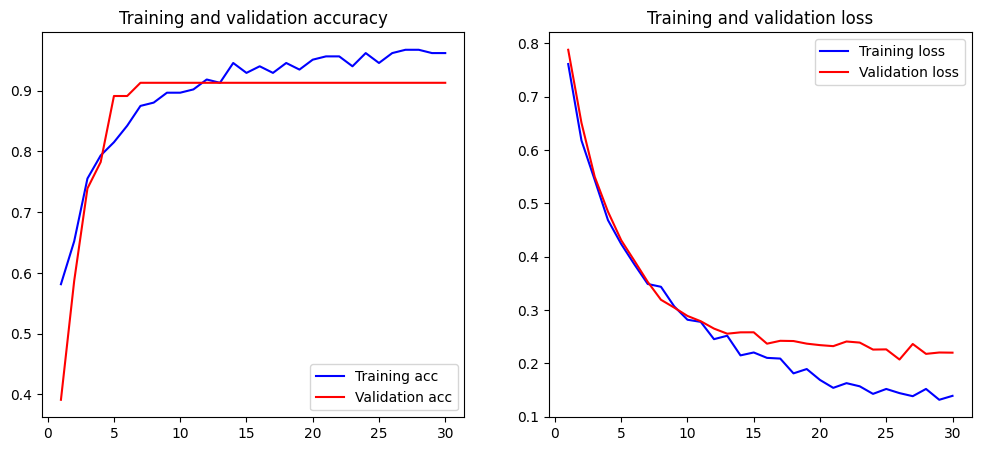

In [ ]:
train_model(X_train, y_train, mode='only_text', model_name='ami_only_text', epochs=30) 

2/2 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0      0.933     0.903     0.918        31
           1      0.889     0.923     0.906        26

    accuracy                          0.912        57
   macro avg      0.911     0.913     0.912        57
weighted avg      0.913     0.912     0.912        57

Accuracy: 0.9122807017543859
Precision: 0.8888888888888888
Recall: 0.9230769230769231


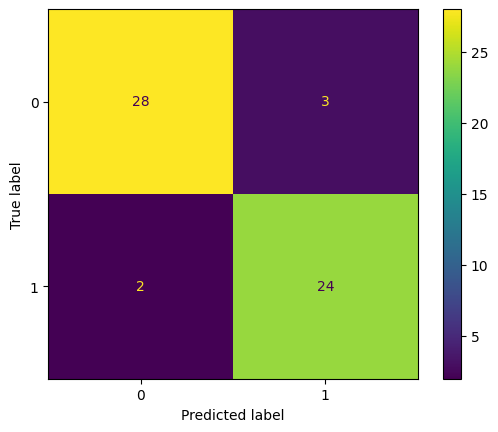

In [ ]:
eval_model(X_test, y_test, mode='only_text', model_name='ami_only_text') 

# AMI concat

## [BEST] 'ami_concat' epochs - 30

In [6]:
X_train_concat = load_input_embeddings('./data/embeddings/ami_train_embeddings.pkl') 
X_train_concat = concat(X_train_concat, file_path = './data/train_set.csv') 
y_train = load_dataset('./data/train_set.csv')['label']


X_test_concat= load_input_embeddings('./data/embeddings/ami_eval_embeddings.pkl')
X_test_concat = concat(X_test_concat, file_path = './data/eval_set.csv') 
y_test = load_dataset('./data/eval_set.csv')['label'] 

## [BEST] Ami Concat - 30 Epochs - ami_concat

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                24704     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 25,249
Trainable params: 25,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
37/37 [==============================] - 3s 25ms/step - loss: 0.7529 - accuracy: 0.5543 - val_loss: 0.5570 - val_accuracy: 0.7609
Epoch 2/30
37/37 [=========================

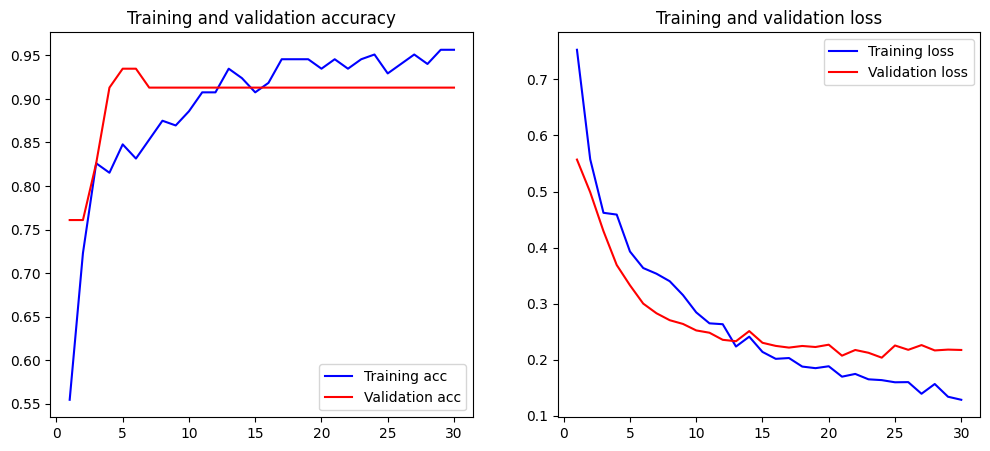

In [ ]:
train_model(X_train_concat, y_train, mode='concat', model_name='ami_concat', epochs=30) 

2/2 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0      0.933     0.903     0.918        31
           1      0.889     0.923     0.906        26

    accuracy                          0.912        57
   macro avg      0.911     0.913     0.912        57
weighted avg      0.913     0.912     0.912        57

Accuracy: 0.9122807017543859
Precision: 0.8888888888888888
Recall: 0.9230769230769231


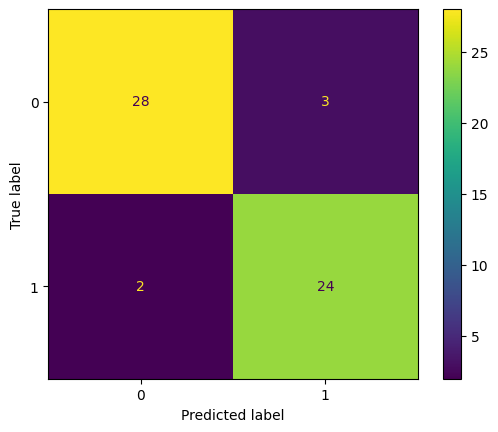

In [11]:
fp, fn = eval_model(X_test_concat, y_test, mode='concat', model_name='ami_concat') 

In [14]:
dataset = load_dataset('./data/eval_set.csv')

dataset.iloc[fp][['transcript', 'arousal', 'valence', 'dominance']]

,transcript,arousal,valence,dominance
2,okay so first of all I don't think its an atta...,0.672102,0.650475,0.466477
24,I think women's fashion is getting kind of out...,0.813189,0.787760,0.642855
27,she is going to be moving on and you are absol...,0.738057,0.764024,0.242208


In [22]:
print(list(dataset.iloc[fn]['transcript'])[0])

women are going to see the world frankly different from men women are very emotional so of course they're going to be worried about you know what's on the badge and all this stuff when we look at the UK right the UK has about 4 million Starving Children right now and that doubled since the past two years do you think that children that are hungry care about some badges they can't eat football badges you know what leftism does is they try to sidestep the real dilemmas and worry about all these Frills on the outside on the exterior Hotel apart from saying that you've made two really good friends here with your women get to emotions and I'll let you three deal with that after the show


## AMI Concat - 32 Epochs - ami_concat_1

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                24704     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 25,249
Trainable params: 25,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
37/37 [==============================] - 3s 20ms/step - loss: 0.6922 - accuracy: 0.5489 - val_loss: 0.6452 - val_accuracy: 0.6304
Epoch 2/32
37/37 [=======================

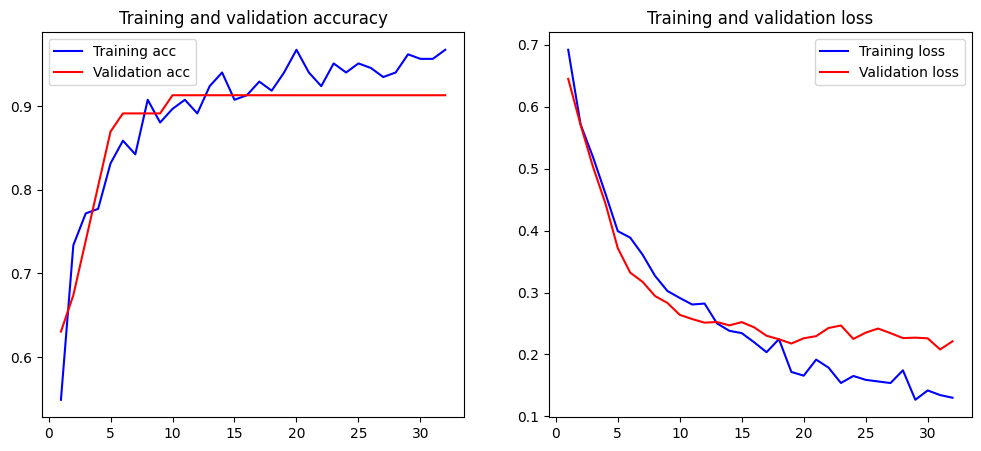

In [ ]:
train_model(X_train_concat, y_train, mode='concat', model_name='ami_concat_1', epochs=32) 

2/2 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

           0      0.871     0.871     0.871        31
           1      0.846     0.846     0.846        26

    accuracy                          0.860        57
   macro avg      0.859     0.859     0.859        57
weighted avg      0.860     0.860     0.860        57

Accuracy: 0.8596491228070176
Precision: 0.8461538461538461
Recall: 0.8461538461538461


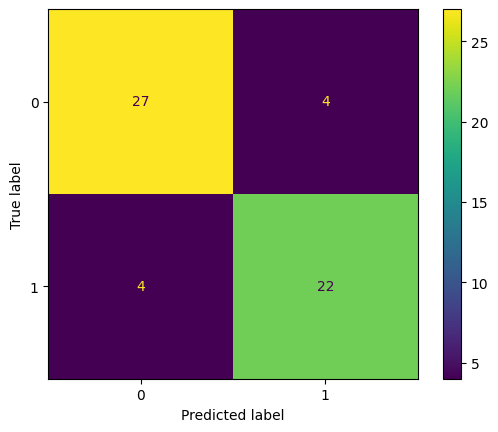

In [ ]:
eval_model(X_test_concat, y_test, mode='concat', model_name='ami_concat_1') 

# AMI Append

In [ ]:
X_train_append = load_input_embeddings('./data/embeddings/ami_train_embeddings.pkl') 
X_train_append = append(X_train_append, './data/train_set.csv') 
y_train = load_dataset('./data/train_set.csv')['label']


X_test_append = load_input_embeddings('./data/embeddings/ami_eval_embeddings.pkl')
X_test_append = append(X_test_append, './data/eval_set.csv') 
y_test = load_dataset('./data/eval_set.csv')['label'] 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2, 64)             49216     
                                                                 
 dropout (Dropout)           (None, 2, 64)             0         
                                                                 
 dense_1 (Dense)             (None, 2, 32)             2080      
                                                                 
 dense_2 (Dense)             (None, 2, 1)              33        
                                                                 
Total params: 51,329
Trainable params: 51,329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
37/37 [==============================] - 1s 8ms/step - loss: 0.6659 - accuracy: 0.5815 - val_loss: 0.6118 - val_accuracy: 0.5543
Epoch 2/20
37/37 [==========================

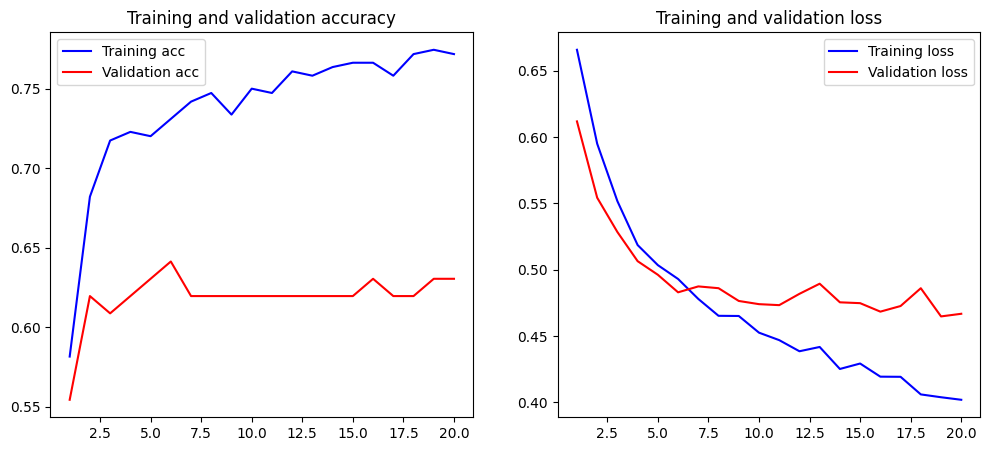

In [ ]:
train_model(X_train_append, y_train, mode='append', model_name='ami_append', epochs=20)  

2/2 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0      0.931     0.871     0.900        31
           1      0.857     0.923     0.889        26

    accuracy                          0.895        57
   macro avg      0.894     0.897     0.894        57
weighted avg      0.897     0.895     0.895        57

Accuracy: 0.8947368421052632
Precision: 0.8571428571428571
Recall: 0.9230769230769231


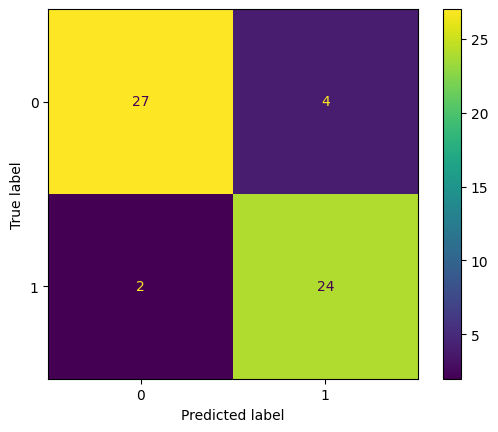

In [ ]:
eval_model(X_test_append, y_test, mode='append', model_name='ami_append')  